In [20]:
setwd('/media/ben/9c17f1c9-a45e-49ec-b547-8fbd2f25ccc6/HMO_biosynthesis/')

#### load libraries
source('functions.R')
source('unittests.r')
library(reshape2)
library(openxlsx)
library(lme4)
library(heatmap.plus)
library(ggrepel)

clean<-function(x,skip=1){
    x = x[,-skip]
    x$Dataset = paste0('d',x$Dataset)
    x$Secretor = ! x$Pateint.ID %in% c('L2','L3')
    x$scretor_col = ifelse(x$Secretor,'black','grey')
    x$DPP_col = heat.colors(length(unique(x$DPP)))[factor(x$DPP)]
    x= droplevels(na.omit(x[ x$Dataset=='d1' ,] ))
    x$subject_col = rainbow(length(levels(x$Pateint.ID)))[x$Pateint.ID]
    x
}

##### load & prep data
ma = clean( read.csv('motifAnyl/motif_abundance.csv') )
mand = clean( read.csv('motifAnyl/motif_abundance_nodes_dropped.csv') )
# mandm = clean( read.csv('motifAnyl/motif_abundance_nodes_dropped_more.csv') )
smandm = clean( read.csv('motifAnyl/smallest_motif_abundance_nodes_dropped_more.csv') )
gly = clean ( tmp<-read.csv('data/raw/Data12.csv'), 21 )

vars = gsub('\\.','',c( grep('X',colnames(ma),value=T), colnames(gly)[4:19] ))

gly_p = gly
gly_p[,colnames(gly)[4:19]] = gly[,colnames(gly)[4:19]]/as.numeric(as.character(gly$SUM))

data=list(motif_abundance=ma,motif_abundance_dropped=mand,#motif_abundance_dropped_more=mandm,
    smallest_motif_abundance_dropped_more=smandm,glycan_concentration=gly,glycan_percent=gly_p)

data = lapply(data,function(x){
    colnames(x) = gsub('\\.','',colnames(x))
    x
})


#######################


### examine glycan and motif level clustering (Supp Fig6)

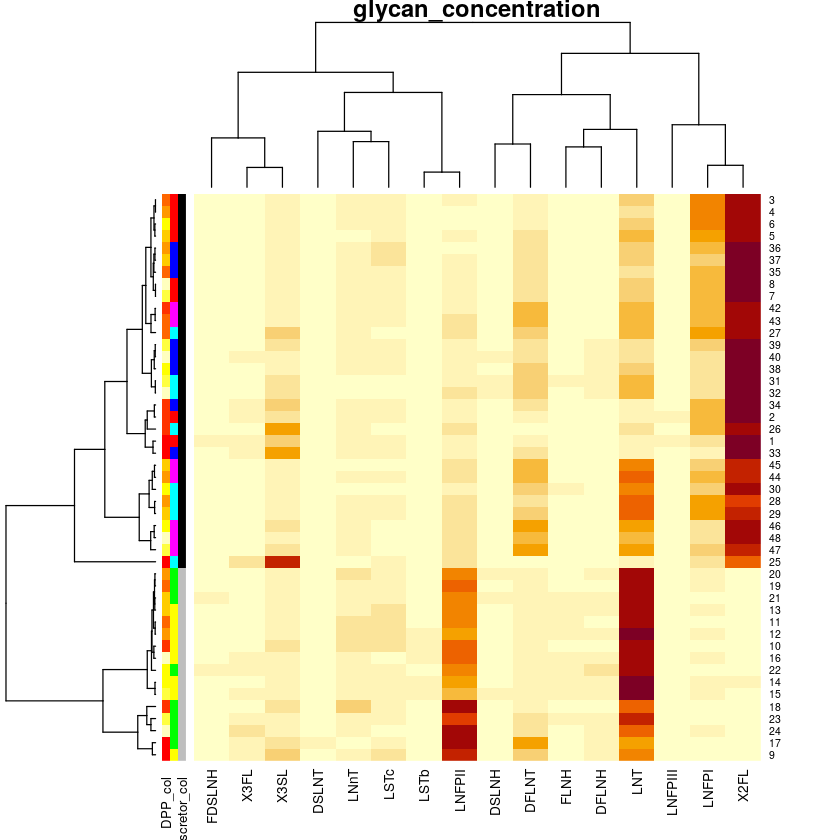

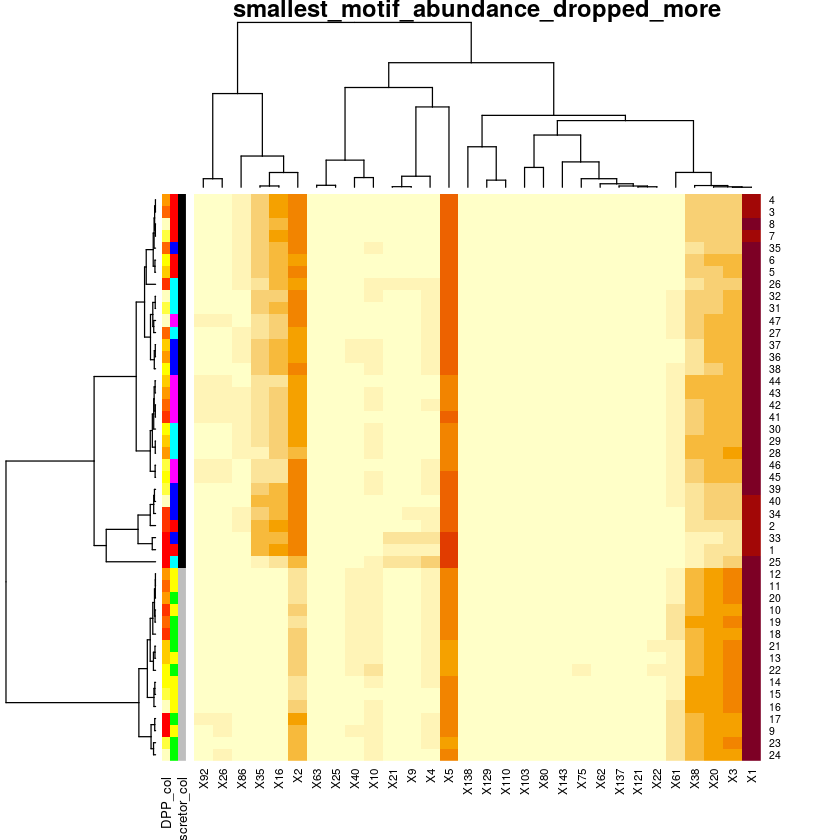

In [21]:

## glycan abundance
x=data$glycan_concentration
data_i = data.matrix(x[,colnames(x)%in%vars])
cols = as.matrix(x[,rev(c('scretor_col','subject_col','DPP_col'))])
heatmap.plus( data_i,RowSideColors=cols,main='glycan_concentration', 
    hclustfun=function(x) hclust(x,method="complete"),distfun=function(x) as.dist((1 - cor(  t(x) ,method='pearson' ))/2))

## motif abundance        
x=data$smallest_motif_abundance_dropped_more
data_i = data.matrix(x[,colnames(x)%in%vars])
cols = as.matrix(x[,rev(c('scretor_col','subject_col','DPP_col'))])
heatmap.plus( data_i,RowSideColors=cols,main='smallest_motif_abundance_dropped_more', 
    hclustfun=function(x) hclust(x,method="complete"),distfun=function(x) as.dist((1 - cor(  t(x) ,method='pearson' ))/2))


# Phenotype-Glycan & Phenotype-Motif Abundance Associations


## Predictability of every glycan and motif from Secretor status and DPP (Supp Fig8, Fig4b)
This analysis discovered several motifs signifiantly associated with secretor status and DPP, including X80

In [23]:

library(lme4)
library(gee)

i=0
out_i=lapply( data, function(x){
    i=i+1
    x$Secretor = as.numeric(x$Secretor)
    #	x$Secretor = relevel(factor(ifelse(x$Secretor,'secretor','nonsecretor')),ref='nonsecretor')
    mods_i = lapply( colnames(x)[colnames(x)%in%vars] , function(motif){
        mod=NA
        try(mod<-gee(as.formula(paste('scale(',motif,')~ Secretor+log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable'))
        if(is.na(mod)){return(NULL)}else{as.data.frame(coef(summary(mod)))}
    })
    names(mods_i) = colnames(x)[colnames(x)%in%vars]
    mods=as.data.frame( do.call(rbind,mods_i[!sapply(mods_i,is.null)]) )
    mods = cbind(mods,do.call(rbind,strsplit( gsub('scale|log|\\(|\\)','',rownames(mods)) , split = '\\.') ) )
    colnames(mods) = c('Coef','naiveSE','naiveZ','robustSE','robustZ','response','vars')
    mods$type = 'additive'
    mods$robustPr = 2*pnorm(-abs(mods$robustZ))
    mods1=mods[mods$response%in%vars & mods$vars!='Intercept',]

    mods_i = lapply( colnames(x)[colnames(x)%in%vars] , function(motif){
        mod=NA
        try(mod<-gee(as.formula(paste('scale(',motif,')~ Secretor*log(DPP)')),id=PateintID,data=droplevels(x),corstr='exchangeable'))
        if(is.na(mod)){return(NULL)}else{as.data.frame(coef(summary(mod)))}
    })
    names(mods_i) = colnames(x)[colnames(x)%in%vars]
    mods=as.data.frame( do.call(rbind,mods_i[!sapply(mods_i,is.null)]) )
    mods = cbind(mods,do.call(rbind,strsplit( gsub('scale|log|\\(|\\)','',rownames(mods)) , split = '\\.') ) )
    colnames(mods) = c('Coef','naiveSE','naiveZ','robustSE','robustZ','response','vars')
    mods$type = 'interaction'
    mods$robustPr = 2*pnorm(-abs(mods$robustZ))
    mods2=mods[mods$response%in%vars & mods$vars!='Intercept',]

    rbind(mods1,mods2)
})
out=do.call(rbind,out_i) #[-(4:5)])
out$data = unlist(lapply(strsplit(rownames(out),'\\.'),function(x) x[1]))


#############
out$response = factor( as.character(out$response), levels = sample(unique(as.character(out$response))))


Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
-0.47264589  0.23479317  0.09161437 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  1.0012165  -1.8807040   0.1263481 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
-1.27521662  1.72338978  0.07314933 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  1.0012165  -1.8807040   0.1263481 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  1.0606472  -0.2090820  -0.4873051 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
-0.47264589  0.23479317  0.09161437 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 1.05953596 -1.75306281  0.05108867 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8982203  -1.8323813   0.1639089 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  1.0459768  -1.8740710   0.1003995 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4787127   0.3530343  -0.3757814 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 1.02172037 -1.43873750 -0.03842804 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.6142237  -1.2148520   0.0987883 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  1.3662931  -0.8147593  -0.4377459 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.3605942   0.4481976   0.0343134 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.3196693  -1.2504980   0.2667605 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.91407330 -1.39020722  0.00151666 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


 (Intercept)     Secretor     log(DPP) 
-1.306688577  1.965361540  0.005485054 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 1.05953596 -1.75306281  0.05108867 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 1.05953596 -1.75306281  0.05108867 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8982203  -1.8323813   0.1639089 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  1.0459768  -1.8740710   0.1003995 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4757873   0.3999163  -0.3905667 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.6142237  -1.2148520   0.0987883 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
   1.276252   -1.188771   -0.259917 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.70492419 -1.15591457  0.03035949 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  1.3662931  -0.8147593  -0.4377459 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.3605942   0.4481976   0.0343134 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.3196693  -1.2504980   0.2667605 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4837784  -1.2623282   0.1842143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.3196693  -1.2504980   0.2667605 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.3196693  -1.2504980   0.2667605 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.05159399 -0.37855031  0.10461143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.91407330 -1.39020722  0.00151666 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.91407330 -1.39020722  0.00151666 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
-1.01367708  1.61471180 -0.02711589 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -1.3129996   1.9460668   0.0155388 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 1.05953596 -1.75306281  0.05108867 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 1.05953596 -1.75306281  0.05108867 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8982203  -1.8323813   0.1639089 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.70492419 -1.15591457  0.03035949 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
   1.276252   -1.188771   -0.259917 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.70492419 -1.15591457  0.03035949 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  1.3187308  -0.6984738  -0.4531331 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7396415   0.8076220   0.1092939 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4837784  -1.2623282   0.1842143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.3196693  -1.2504980   0.2667605 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4837784  -1.2623282   0.1842143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.60567784 -1.20131597  0.09858646 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.60567784 -1.20131597  0.09858646 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.3196693  -1.2504980   0.2667605 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4837784  -1.2623282   0.1842143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.3196693  -1.2504980   0.2667605 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.05159399 -0.37855031  0.10461143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.91407330 -1.39020722  0.00151666 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.05159399 -0.37855031  0.10461143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.91407330 -1.39020722  0.00151666 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7129131  -0.1829127   0.4402064 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.1696053  -0.9704151   0.4275892 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
-1.01367708  1.61471180 -0.02711589 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8465822  -0.8400809  -0.1544636 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8465822  -0.8400809  -0.1544636 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 1.05953596 -1.75306281  0.05108867 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.70492419 -1.15591457  0.03035949 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  1.3187308  -0.6984738  -0.4531331 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7396415   0.8076220   0.1092939 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7396415   0.8076220   0.1092939 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4837784  -1.2623282   0.1842143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.60567784 -1.20131597  0.09858646 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.60567784 -1.20131597  0.09858646 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.60567784 -1.20131597  0.09858646 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4837784  -1.2623282   0.1842143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4837784  -1.2623282   0.1842143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4837784  -1.2623282   0.1842143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.60567784 -1.20131597  0.09858646 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.60567784 -1.20131597  0.09858646 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.3196693  -1.2504980   0.2667605 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4837784  -1.2623282   0.1842143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.05159399 -0.37855031  0.10461143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7129131  -0.1829127   0.4402064 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.05159399 -0.37855031  0.10461143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.91407330 -1.39020722  0.00151666 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7129131  -0.1829127   0.4402064 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7129131  -0.1829127   0.4402064 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7129131  -0.1829127   0.4402064 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.1696053  -0.9704151   0.4275892 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.1696053  -0.9704151   0.4275892 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
-1.01367708  1.61471180 -0.02711589 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.2472766  -1.3190719   0.3288775 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8465822  -0.8400809  -0.1544636 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8465822  -0.8400809  -0.1544636 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8465822  -0.8400809  -0.1544636 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8465822  -0.8400809  -0.1544636 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7396415   0.8076220   0.1092939 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.60567784 -1.20131597  0.09858646 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4837784  -1.2623282   0.1842143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4837784  -1.2623282   0.1842143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4837784  -1.2623282   0.1842143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.60567784 -1.20131597  0.09858646 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.60567784 -1.20131597  0.09858646 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.60567784 -1.20131597  0.09858646 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4837784  -1.2623282   0.1842143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4837784  -1.2623282   0.1842143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4837784  -1.2623282   0.1842143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.05159399 -0.37855031  0.10461143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7129131  -0.1829127   0.4402064 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7129131  -0.1829127   0.4402064 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7129131  -0.1829127   0.4402064 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7129131  -0.1829127   0.4402064 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7129131  -0.1829127   0.4402064 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7129131  -0.1829127   0.4402064 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.1696053  -0.9704151   0.4275892 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.2472766  -1.3190719   0.3288775 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.2472766  -1.3190719   0.3288775 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8465822  -0.8400809  -0.1544636 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8465822  -0.8400809  -0.1544636 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8465822  -0.8400809  -0.1544636 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8465822  -0.8400809  -0.1544636 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8465822  -0.8400809  -0.1544636 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8465822  -0.8400809  -0.1544636 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8465822  -0.8400809  -0.1544636 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4837784  -1.2623282   0.1842143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.60567784 -1.20131597  0.09858646 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4837784  -1.2623282   0.1842143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4837784  -1.2623282   0.1842143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4837784  -1.2623282   0.1842143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7129131  -0.1829127   0.4402064 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7129131  -0.1829127   0.4402064 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7129131  -0.1829127   0.4402064 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7129131  -0.1829127   0.4402064 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.2472766  -1.3190719   0.3288775 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8465822  -0.8400809  -0.1544636 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8465822  -0.8400809  -0.1544636 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8465822  -0.8400809  -0.1544636 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8465822  -0.8400809  -0.1544636 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8465822  -0.8400809  -0.1544636 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8465822  -0.8400809  -0.1544636 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8465822  -0.8400809  -0.1544636 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4837784  -1.2623282   0.1842143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7129131  -0.1829127   0.4402064 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8465822  -0.8400809  -0.1544636 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8465822  -0.8400809  -0.1544636 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8465822  -0.8400809  -0.1544636 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8465822  -0.8400809  -0.1544636 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8465822  -0.8400809  -0.1544636 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -0.6671037         0.5376777         0.1964936        -0.1615308 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       1.10904390       -2.04865433        0.06819229        0.08956926 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
      -1.04810981        1.36965163       -0.04933886        0.18865146 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       1.10904390       -2.04865433        0.06819229        0.08956926 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       1.16996632       -0.37935579       -0.54626548        0.09080839 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -0.6671037         0.5376777         0.1964936        -0.1615308 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.3543089        -2.2121967        -0.1078947         0.2448599 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.92609586       -1.87579984        0.14887449        0.02315548 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       1.15789744       -2.04839691        0.04003603        0.09296943 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        0.2614408         0.6914537        -0.2585976        -0.1804819 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.3597015        -1.9651718        -0.2207154         0.2807517 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.51624938       -1.06224870        0.15162993       -0.08138459 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.7418740        -1.3997585        -0.6403124         0.3119849 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.04044809       -0.17645985       -0.18198547        0.33313496 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.35930783       -1.31223837        0.24538174        0.03292666 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.9404063        -2.9888081        -0.5520276         0.8525470 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
      -1.34636100        2.02715470        0.02688205       -0.03295480 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.3543089        -2.2121967        -0.1078947         0.2448599 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.3543089        -2.2121967        -0.1078947         0.2448599 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.92609586       -1.87579984        0.14887449        0.02315548 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       1.15789744       -2.04839691        0.04003603        0.09296943 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        0.1325613         0.9345200        -0.2054505        -0.2851086 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.51624938       -1.06224870        0.15162993       -0.08138459 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.7486815        -1.9246205        -0.5147181         0.3924346 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        0.5525585        -0.9185921         0.1125367        -0.1265660 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.7418740        -1.3997585        -0.6403124         0.3119849 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.04044809       -0.17645985       -0.18198547        0.33313496 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.35930783       -1.31223837        0.24538174        0.03292666 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.45778353       -1.22183889        0.19823442       -0.02159327 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.35930783       -1.31223837        0.24538174        0.03292666 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.35930783       -1.31223837        0.24538174        0.03292666 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.1094635        -2.0262719        -0.4659418         0.8787435 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.9404063        -2.9888081        -0.5520276         0.8525470 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.9404063        -2.9888081        -0.5520276         0.8525470 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -1.2454158         1.9756646         0.0978705        -0.1924991 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
     -1.288629055       1.908107542       0.002394737       0.020243965 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.3543089        -2.2121967        -0.1078947         0.2448599 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.3543089        -2.2121967        -0.1078947         0.2448599 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.92609586       -1.87579984        0.14887449        0.02315548 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        0.5525585        -0.9185921         0.1125367        -0.1265660 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.7486815        -1.9246205        -0.5147181         0.3924346 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        0.5525585        -0.9185921         0.1125367        -0.1265660 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.7519363        -1.3732281        -0.6867789         0.3598520 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
      -0.06903811       -0.23689979       -0.25239051        0.55705202 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.45778353       -1.22183889        0.19823442       -0.02159327 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.35930783       -1.31223837        0.24538174        0.03292666 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.45778353       -1.22183889        0.19823442       -0.02159327 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.57552539       -1.15435095        0.11484894       -0.02504683 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.57552539       -1.15435095        0.11484894       -0.02504683 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.35930783       -1.31223837        0.24538174        0.03292666 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.45778353       -1.22183889        0.19823442       -0.02159327 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.35930783       -1.31223837        0.24538174        0.03292666 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.1094635        -2.0262719        -0.4659418         0.8787435 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.9404063        -2.9888081        -0.5520276         0.8525470 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.1094635        -2.0262719        -0.4659418         0.8787435 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.9404063        -2.9888081        -0.5520276         0.8525470 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -0.2874502        -0.8456074         0.2107364         0.3534205 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
      -0.04339716       -1.16699496        0.35951991        0.10483764 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -1.2454158         1.9756646         0.0978705        -0.1924991 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80973227       -0.78268391       -0.13458892       -0.03061026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80973227       -0.78268391       -0.13458892       -0.03061026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.3543089        -2.2121967        -0.1078947         0.2448599 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        0.5525585        -0.9185921         0.1125367        -0.1265660 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.7519363        -1.3732281        -0.6867789         0.3598520 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
      -0.06903811       -0.23689979       -0.25239051        0.55705202 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
      -0.06903811       -0.23689979       -0.25239051        0.55705202 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.45778353       -1.22183889        0.19823442       -0.02159327 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.57552539       -1.15435095        0.11484894       -0.02504683 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.57552539       -1.15435095        0.11484894       -0.02504683 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.57552539       -1.15435095        0.11484894       -0.02504683 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.45778353       -1.22183889        0.19823442       -0.02159327 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.45778353       -1.22183889        0.19823442       -0.02159327 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.45778353       -1.22183889        0.19823442       -0.02159327 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.57552539       -1.15435095        0.11484894       -0.02504683 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.57552539       -1.15435095        0.11484894       -0.02504683 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.35930783       -1.31223837        0.24538174        0.03292666 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.45778353       -1.22183889        0.19823442       -0.02159327 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.1094635        -2.0262719        -0.4659418         0.8787435 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -0.2874502        -0.8456074         0.2107364         0.3534205 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.1094635        -2.0262719        -0.4659418         0.8787435 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.9404063        -2.9888081        -0.5520276         0.8525470 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -0.2874502        -0.8456074         0.2107364         0.3534205 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -0.2874502        -0.8456074         0.2107364         0.3534205 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -0.2874502        -0.8456074         0.2107364         0.3534205 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
      -0.04339716       -1.16699496        0.35951991        0.10483764 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
      -0.04339716       -1.16699496        0.35951991        0.10483764 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -1.2454158         1.9756646         0.0978705        -0.1924991 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.13697479       -1.14726756        0.38836783       -0.09162468 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80973227       -0.78268391       -0.13458892       -0.03061026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80973227       -0.78268391       -0.13458892       -0.03061026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80973227       -0.78268391       -0.13458892       -0.03061026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80973227       -0.78268391       -0.13458892       -0.03061026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
      -0.06903811       -0.23689979       -0.25239051        0.55705202 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.57552539       -1.15435095        0.11484894       -0.02504683 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.45778353       -1.22183889        0.19823442       -0.02159327 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.45778353       -1.22183889        0.19823442       -0.02159327 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.45778353       -1.22183889        0.19823442       -0.02159327 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.57552539       -1.15435095        0.11484894       -0.02504683 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.57552539       -1.15435095        0.11484894       -0.02504683 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.57552539       -1.15435095        0.11484894       -0.02504683 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.45778353       -1.22183889        0.19823442       -0.02159327 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.45778353       -1.22183889        0.19823442       -0.02159327 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.45778353       -1.22183889        0.19823442       -0.02159327 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.1094635        -2.0262719        -0.4659418         0.8787435 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -0.2874502        -0.8456074         0.2107364         0.3534205 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -0.2874502        -0.8456074         0.2107364         0.3534205 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -0.2874502        -0.8456074         0.2107364         0.3534205 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -0.2874502        -0.8456074         0.2107364         0.3534205 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -0.2874502        -0.8456074         0.2107364         0.3534205 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -0.2874502        -0.8456074         0.2107364         0.3534205 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
      -0.04339716       -1.16699496        0.35951991        0.10483764 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.13697479       -1.14726756        0.38836783       -0.09162468 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.13697479       -1.14726756        0.38836783       -0.09162468 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80973227       -0.78268391       -0.13458892       -0.03061026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80973227       -0.78268391       -0.13458892       -0.03061026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80973227       -0.78268391       -0.13458892       -0.03061026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80973227       -0.78268391       -0.13458892       -0.03061026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80973227       -0.78268391       -0.13458892       -0.03061026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80973227       -0.78268391       -0.13458892       -0.03061026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80973227       -0.78268391       -0.13458892       -0.03061026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.45778353       -1.22183889        0.19823442       -0.02159327 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.57552539       -1.15435095        0.11484894       -0.02504683 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.45778353       -1.22183889        0.19823442       -0.02159327 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.45778353       -1.22183889        0.19823442       -0.02159327 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.45778353       -1.22183889        0.19823442       -0.02159327 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -0.2874502        -0.8456074         0.2107364         0.3534205 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -0.2874502        -0.8456074         0.2107364         0.3534205 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -0.2874502        -0.8456074         0.2107364         0.3534205 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -0.2874502        -0.8456074         0.2107364         0.3534205 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.13697479       -1.14726756        0.38836783       -0.09162468 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80973227       -0.78268391       -0.13458892       -0.03061026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80973227       -0.78268391       -0.13458892       -0.03061026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80973227       -0.78268391       -0.13458892       -0.03061026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80973227       -0.78268391       -0.13458892       -0.03061026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80973227       -0.78268391       -0.13458892       -0.03061026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80973227       -0.78268391       -0.13458892       -0.03061026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80973227       -0.78268391       -0.13458892       -0.03061026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.45778353       -1.22183889        0.19823442       -0.02159327 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -0.2874502        -0.8456074         0.2107364         0.3534205 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80973227       -0.78268391       -0.13458892       -0.03061026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80973227       -0.78268391       -0.13458892       -0.03061026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80973227       -0.78268391       -0.13458892       -0.03061026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80973227       -0.78268391       -0.13458892       -0.03061026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80973227       -0.78268391       -0.13458892       -0.03061026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
-0.47264589  0.23479317  0.09161437 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  1.0459768  -1.8740710   0.1003995 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4757873   0.3999163  -0.3905667 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.3605942   0.4481976   0.0343134 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -1.3129996   1.9460668   0.0155388 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8982203  -1.8323813   0.1639089 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
   1.276252   -1.188771   -0.259917 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 1.05953596 -1.75306281  0.05108867 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.70492419 -1.15591457  0.03035949 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  1.3187308  -0.6984738  -0.4531331 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.3196693  -1.2504980   0.2667605 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.91407330 -1.39020722  0.00151666 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
-1.01367708  1.61471180 -0.02711589 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7396415   0.8076220   0.1092939 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.05159399 -0.37855031  0.10461143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.1696053  -0.9704151   0.4275892 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.60567784 -1.20131597  0.09858646 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.2472766  -1.3190719   0.3288775 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4837784  -1.2623282   0.1842143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7129131  -0.1829127   0.4402064 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8465822  -0.8400809  -0.1544636 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -0.6671037         0.5376777         0.1964936        -0.1615308 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       1.15789744       -2.04839691        0.04003603        0.09296943 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        0.1325613         0.9345200        -0.2054505        -0.2851086 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.04044809       -0.17645985       -0.18198547        0.33313496 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
     -1.288629055       1.908107542       0.002394737       0.020243965 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.92609586       -1.87579984        0.14887449        0.02315548 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.7486815        -1.9246205        -0.5147181         0.3924346 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.3543089        -2.2121967        -0.1078947         0.2448599 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        0.5525585        -0.9185921         0.1125367        -0.1265660 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.7519363        -1.3732281        -0.6867789         0.3598520 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.35930783       -1.31223837        0.24538174        0.03292666 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.9404063        -2.9888081        -0.5520276         0.8525470 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -1.2454158         1.9756646         0.0978705        -0.1924991 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
      -0.06903811       -0.23689979       -0.25239051        0.55705202 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.1094635        -2.0262719        -0.4659418         0.8787435 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
      -0.04339716       -1.16699496        0.35951991        0.10483764 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.57552539       -1.15435095        0.11484894       -0.02504683 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.13697479       -1.14726756        0.38836783       -0.09162468 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.45778353       -1.22183889        0.19823442       -0.02159327 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -0.2874502        -0.8456074         0.2107364         0.3534205 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80973227       -0.78268391       -0.13458892       -0.03061026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  1.0012165  -1.8807040   0.1263481 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
-1.27521662  1.72338978  0.07314933 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  1.0012165  -1.8807040   0.1263481 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  1.0606472  -0.2090820  -0.4873051 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
-0.47264589  0.23479317  0.09161437 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4787127   0.3530343  -0.3757814 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 1.02172037 -1.43873750 -0.03842804 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


 (Intercept)     Secretor     log(DPP) 
-1.306688577  1.965361540  0.005485054 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  1.0459768  -1.8740710   0.1003995 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4757873   0.3999163  -0.3905667 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.6142237  -1.2148520   0.0987883 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  1.3662931  -0.8147593  -0.4377459 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.3605942   0.4481976   0.0343134 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -1.3129996   1.9460668   0.0155388 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8982203  -1.8323813   0.1639089 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
   1.276252   -1.188771   -0.259917 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 1.05953596 -1.75306281  0.05108867 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.70492419 -1.15591457  0.03035949 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  1.3187308  -0.6984738  -0.4531331 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.3196693  -1.2504980   0.2667605 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.91407330 -1.39020722  0.00151666 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
-1.01367708  1.61471180 -0.02711589 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7396415   0.8076220   0.1092939 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.05159399 -0.37855031  0.10461143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.1696053  -0.9704151   0.4275892 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.60567784 -1.20131597  0.09858646 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.2472766  -1.3190719   0.3288775 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4837784  -1.2623282   0.1842143 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7129131  -0.1829127   0.4402064 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8465822  -0.8400809  -0.1544636 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       1.10904390       -2.04865433        0.06819229        0.08956926 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
      -1.04810981        1.36965163       -0.04933886        0.18865146 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       1.10904390       -2.04865433        0.06819229        0.08956926 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       1.16996632       -0.37935579       -0.54626548        0.09080839 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -0.6671037         0.5376777         0.1964936        -0.1615308 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        0.2614408         0.6914537        -0.2585976        -0.1804819 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.3597015        -1.9651718        -0.2207154         0.2807517 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
      -1.34636100        2.02715470        0.02688205       -0.03295480 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       1.15789744       -2.04839691        0.04003603        0.09296943 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        0.1325613         0.9345200        -0.2054505        -0.2851086 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.51624938       -1.06224870        0.15162993       -0.08138459 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.7418740        -1.3997585        -0.6403124         0.3119849 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.04044809       -0.17645985       -0.18198547        0.33313496 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
     -1.288629055       1.908107542       0.002394737       0.020243965 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.92609586       -1.87579984        0.14887449        0.02315548 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.7486815        -1.9246205        -0.5147181         0.3924346 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.3543089        -2.2121967        -0.1078947         0.2448599 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        0.5525585        -0.9185921         0.1125367        -0.1265660 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.7519363        -1.3732281        -0.6867789         0.3598520 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.35930783       -1.31223837        0.24538174        0.03292666 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.9404063        -2.9888081        -0.5520276         0.8525470 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -1.2454158         1.9756646         0.0978705        -0.1924991 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
      -0.06903811       -0.23689979       -0.25239051        0.55705202 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.1094635        -2.0262719        -0.4659418         0.8787435 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
      -0.04339716       -1.16699496        0.35951991        0.10483764 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.57552539       -1.15435095        0.11484894       -0.02504683 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.13697479       -1.14726756        0.38836783       -0.09162468 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.45778353       -1.22183889        0.19823442       -0.02159327 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -0.2874502        -0.8456074         0.2107364         0.3534205 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80973227       -0.78268391       -0.13458892       -0.03061026 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7571396   1.7348473  -0.2044409 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.7989705   0.0885337  -0.4527792 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.3479464   0.2344505  -0.2654173 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.3372367   0.7697503  -0.4462197 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.38728120 -0.38817226 -0.06931526 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.6367004   1.5218034  -0.1938370 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  1.1781999  -1.1293233  -0.2288424 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.2549094   0.8558264  -0.4327247 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  1.2515292  -1.0073508  -0.3100541 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.5273879   0.6823566  -0.5161982 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
-0.61312070  1.20575471 -0.09620197 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.6944173   0.3511491  -0.4890395 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
-0.23083132 -0.09933758  0.15650504 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 0.20975955 -0.27969319 -0.01335107 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.6654566   0.1129667  -0.3907804 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.8002477   0.5609459   0.2272238 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
    -1.1367089091      2.3260587128      0.0002766671     -0.3152979148 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        0.4695609         0.6016172        -0.2751148        -0.2736316 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        0.8099267        -0.4851231        -0.5145826         0.3837545 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -0.1376133         1.5093694        -0.1901133        -0.3944450 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        0.9278003        -1.2300767        -0.3608398         0.4489945 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
      -0.96089729        2.02676757       -0.01898411       -0.26930154 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.8601507        -2.1915195        -0.5966469         0.5664780 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
      -0.42890796        1.92093001       -0.06391343       -0.56802850 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        2.2267290        -2.5263073        -0.8360201         0.8100720 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.57857238        0.60263237       -0.54380415        0.04251759 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -0.3701815         0.8273563        -0.2272292         0.2018030 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.0819534        -0.2524713        -0.6980539         0.3219157 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.24015186       -0.83293391       -0.09751586        0.39123294 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        0.7751373        -1.1603171        -0.3182829         0.4696439 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.62469418        0.17645769       -0.36879551       -0.03386027 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
      -0.35013216       -0.14014737       -0.01554232        0.37389878 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
-1.31298128  1.94606029  0.01553137 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.7439054  -0.6880259  -0.1532040 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.7024986  -0.7380837  -0.1139004 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4757707   0.3999493  -0.3905694 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.7906527  -1.7580189   0.1948137 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
-0.97730632  1.68303166 -0.07012099 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


 (Intercept)     Secretor     log(DPP) 
 1.292966027 -1.988773771  0.009916963 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4808912   0.3532172  -0.3769956 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  1.3477721  -1.7514596  -0.1016889 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  1.1785173  -0.5137731  -0.4434215 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7396728   0.8076801   0.1092902 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.9301017  -0.2307480  -0.4108165 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.2472641  -1.3190464   0.3288752 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.4838171  -1.2624467   0.1842351 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
  0.8466528  -0.8400613  -0.1545077 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


(Intercept)    Secretor    log(DPP) 
 -0.7129560  -0.1828521   0.4402079 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
     -1.288625005       1.908123319       0.002395015       0.020232097 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.23844986        0.09926401        0.11940933       -0.41986820 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.3351181        -1.7234424        -0.4550986         0.5254999 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        0.1325248         0.9345840        -0.2054426        -0.2851250 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        0.6325142        -1.5117047         0.2801044        -0.1313614 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -1.1779900         1.9956136         0.0381161        -0.1667025 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       1.33573313       -2.05538717       -0.01314912        0.03552547 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
      -0.17577412        1.37602922       -0.02282859       -0.54547404 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.8667880        -2.5598710        -0.3816158         0.4311324 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.6544359        -1.2550567        -0.7001043         0.3953326 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
      -0.06907473       -0.23683344       -0.25239136        0.55704762 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
        1.6793073        -1.3976993        -0.8148944         0.6223447 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.13699857       -1.14729858        0.38834599       -0.09159455 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.45788057       -1.22204829        0.19822378       -0.02154478 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       0.80985193       -0.78274080       -0.13465948       -0.03056948 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”Beginning Cgee S-function, @(#) geeformula.q 4.13 98/01/27
running glm to get initial regression estimate


      (Intercept)          Secretor          log(DPP) Secretor:log(DPP) 
       -0.2874568        -0.8456031         0.2107184         0.3534506 


Warning message in if (is.na(mod)) {:
“the condition has length > 1 and only the first element will be used”

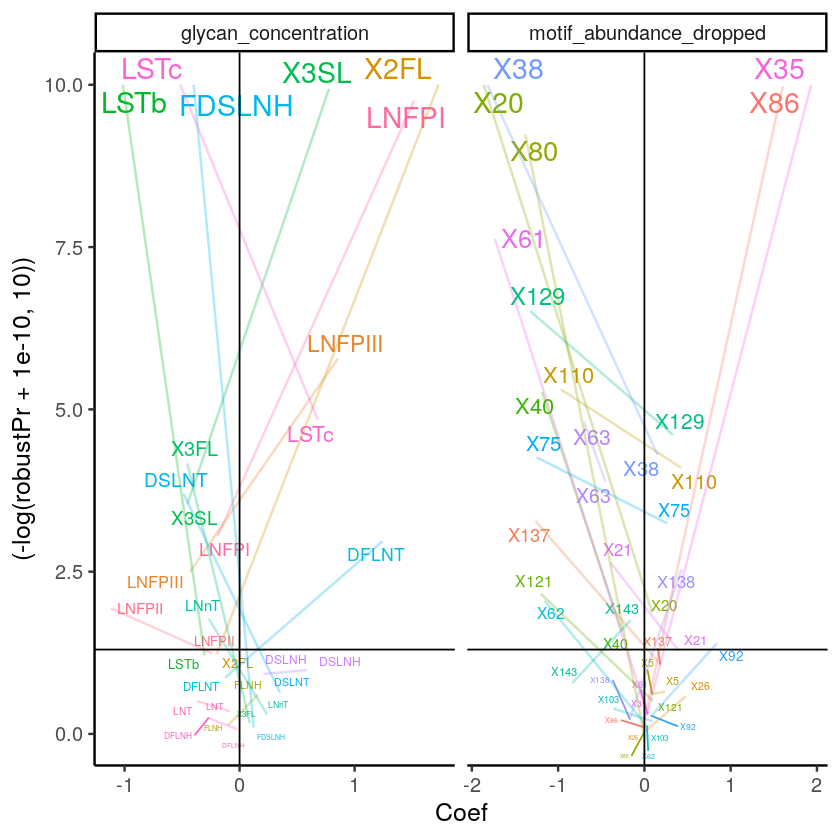

In [45]:
ggplot( data=droplevels(out[out$type=='additive' & out$data%in%keep_data,]) , aes(x=Coef,y=(-log(robustPr+1e-10,10)),size=(-log(robustPr+1e-10,10)),
        label=response,color=response,group=response,shape=vars))+
    geom_text_repel() + geom_path(size=.7,alpha=.3)+
    facet_grid(~data,scale='free')+geom_hline(yintercept=1.3)+geom_vline(xintercept=0)+ guides(color=FALSE,size=FALSE)+
    theme_classic(base_size=15)#+geom_point(size=3)

## Demonstration that X80 behaves distinctly from its related glycans (Fig4b)

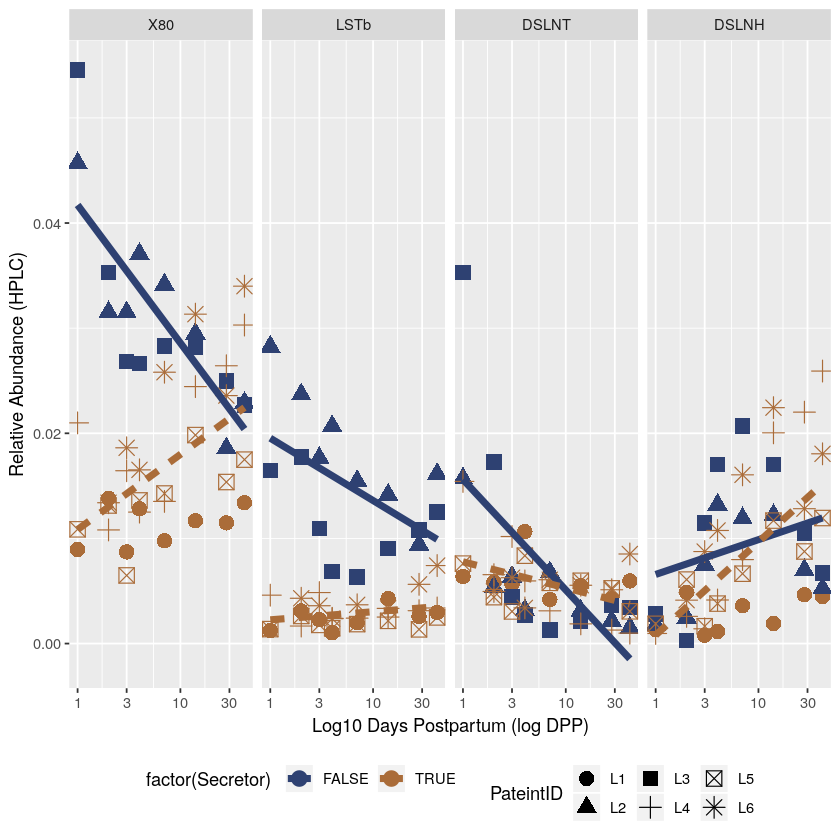

In [55]:
tmp= melt(cbind( data[[3]][,c('DPP','X80','Secretor','PateintID')],data[[5]][,c('DSLNT','DSLNH','LSTb')]) , id.vars=c('DPP','Secretor','PateintID'))

tmp$variable = factor(tmp$variable,levels=c('X80','LSTb','DSLNT','DSLNH'))
ggplot(data=droplevels(tmp),aes(x=DPP,y=value,linetype=Secretor,color=factor(Secretor)))+
		geom_point(aes(shape=PateintID),size=4)+scale_x_log10()+theme(legend.position="bottom")+
		xlab('Log10 Days Postpartum (log DPP)')+ylab('Relative Abundance (HPLC)')+
		stat_smooth(method='lm',size=2,se=F)+facet_grid(cols=vars(variable))+ 
        scale_color_manual(values=c("#2E4172", "#AA6C39"))+guides(linetype=F)


## Using the Product-Reactant ratio association to phenotype to determine important reactions in biosynthesis (Fig5 supporting exploration)

In [64]:
#### load heirachy
r = read.csv('motifAnyl/motif_heir.12.7.18.Bokan/edges.txt',header=F)
heir = graph_from_edgelist( cbind( as.character(r[,1]) , as.character(r[,2]) ))
#plot(heir, layout=layout_as_tree(heir))

#### data
tmp = data[[1]]

comp=list()
comp_clean=list()
p = c(); lfc=c()
for( e in E(heir)){
    p = c(p,1);
    lfc=c(lfc,0);

    print(ends(heir,e))
    en=as.character(ends(heir,e))
    if(any(! paste0('X',en) %in% colnames(tmp) )){print(paste('skip',paste(en,collapse='_')));next}
    if( !all( apply(tmp[,paste0('X',en)],2,sd) > 1e-4 ) | all( tmp[[paste0('X',en[1])]] == tmp[[paste0('X',en[2])]] ) ){
        print(paste('skip',paste(en,collapse='_')));next}
    # run models
    f1 = Secretor ~ log(DPP)
    f2 = as.formula(paste0('Secretor ~ log(DPP) + I(',paste(paste0('X',rev(en)),collapse='/'),')'  ) )

    m1 = geeglm( f1, id=PateintID,data=tmp,corstr='exchangeable',family='binomial')
    m2 = geeglm( f2 , id=PateintID,data=tmp,corstr='exchangeable',family='binomial')

    f0 = as.formula(paste0('Secretor ~ scale(X',en[1],')'))
    f = as.formula(paste0('Secretor ~  scale(X',en[1],') + scale(X',en[2],')'  ) )

    m0 = geeglm( f0, id=PateintID,data=tmp,corstr='exchangeable',family='binomial')
    m = geeglm( f , id=PateintID,data=tmp,corstr='exchangeable',family='binomial')

    aov = anova(m0,m,test='LRT')

    out = data.frame( coef(summary(m2)) )
    out$iter = paste(en,collapse='_')
    out$vars = rownames(out)
    out$LRT = aov[[3]]

    #if(any(abs(out$Estimate)>15)){next}

    p[length(p)] = aov[[3]]
    lfc[length(lfc)] = coef(summary(m2))[3,1]

    comp[[paste(en,collapse='_')]] = list(m1,m2,aov,m)
    comp_clean[[paste(en,collapse='_')]] = out
}

out=do.call(rbind,comp_clean)
out = out[!grepl('Intercept|DPP',rownames(out)),]
#write.csv(out,file='motifAnyl/motif_heir.12.7.18.Bokan/stats.csv')


     [,1] [,2]
[1,] "5"  "20"
[1] "skip 5_20"
     [,1] [,2]
[1,] "5"  "21"
[1] "skip 5_21"
     [,1] [,2]
[1,] "5"  "26"
[1] "skip 5_26"
     [,1] [,2]
[1,] "5"  "29"
[1] "skip 5_29"
     [,1] [,2]
[1,] "5"  "35"
[1] "skip 5_35"
     [,1] [,2]
[1,] "20" "37"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "38"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "40"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "41"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "43"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "51"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "53"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "26" "43"
     [,1] [,2]
[1,] "29" "45"
[1] "skip 29_45"
     [,1] [,2]
[1,] "29" "46"
     [,1] [,2]
[1,] "29" "51"
[1] "skip 29_51"
     [,1] [,2]
[1,] "37" "61"
[1] "skip 37_61"
     [,1] [,2]
[1,] "37" "64"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "61"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "65"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "79"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "80"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "85"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "86"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "40" "62"
     [,1] [,2]
[1,] "40" "63"
     [,1] [,2]
[1,] "40" "73"
     [,1] [,2]
[1,] "41" "62"
[1] "skip 41_62"
     [,1] [,2]
[1,] "41" "74"
     [,1] [,2]
[1,] "43" "64"
[1] "skip 43_64"
     [,1] [,2]
[1,] "43" "65"
[1] "skip 43_65"
     [,1] [,2]
[1,] "45" "66"
     [,1] [,2]
[1,] "45" "75"
[1] "skip 45_75"
     [,1] [,2]
[1,] "45" "88"
     [,1] [,2]
[1,] "46" "66"
[1] "skip 46_66"
     [,1] [,2]
[1,] "46" "76"
[1] "skip 46_76"
     [,1] [,2]
[1,] "51" "73"
     [,1] [,2]
[1,] "51" "74"
     [,1] [,2]
[1,] "51" "75"
[1] "skip 51_75"
     [,1] [,2]
[1,] "51" "76"
     [,1] [,2]
[1,] "51" "81"
     [,1] [,2]
[1,] "51" "85"
     [,1] [,2]
[1,] "53" "80"
[1] "skip 53_80"
     [,1] [,2]
[1,] "53" "81"
     [,1] [,2]
[1,] "61" "92"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "62" "97"
     [,1] [,2] 
[1,] "62" "113"
     [,1] [,2] 
[1,] "63" "113"
     [,1] [,2] 
[1,] "63" "116"
     [,1] [,2]
[1,] "64" "92"
[1] "skip 64_92"
     [,1] [,2]
[1,] "65" "92"
[1] "skip 65_92"
     [,1] [,2] 
[1,] "66" "102"
[1] "skip 66_102"
     [,1] [,2]
[1,] "73" "97"
[1] "skip 73_97"
     [,1] [,2]
[1,] "73" "98"
[1] "skip 73_98"
     [,1] [,2] 
[1,] "73" "100"
     [,1] [,2] 
[1,] "73" "116"
     [,1] [,2]
[1,] "74" "97"
[1] "skip 74_97"
     [,1] [,2]
[1,] "74" "99"
[1] "skip 74_99"
     [,1] [,2] 
[1,] "74" "101"
     [,1] [,2]
[1,] "75" "98"
     [,1] [,2]
[1,] "75" "99"
     [,1] [,2] 
[1,] "75" "102"
     [,1] [,2] 
[1,] "75" "104"
     [,1] [,2] 
[1,] "75" "110"
     [,1] [,2] 
[1,] "75" "117"
     [,1] [,2] 
[1,] "76" "100"
[1] "skip 76_100"
     [,1] [,2] 
[1,] "76" "101"
[1] "skip 76_101"
     [,1] [,2] 
[1,] "76" "102"
[1] "skip 76_102"
     [,1] [,2] 
[1,] "79" "103"
[1] "skip 79_103"
     [,1] [,2] 
[1,] "79" "108"
     [,1] [,2] 
[1,] "80" 

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2] 
[1,] "80" "109"
     [,1] [,2] 
[1,] "81" "104"
[1] "skip 81_104"
     [,1] [,2] 
[1,] "81" "109"
[1] "skip 81_109"
     [,1] [,2] 
[1,] "85" "108"
     [,1] [,2] 
[1,] "85" "109"
     [,1] [,2] 
[1,] "85" "110"
[1] "skip 85_110"
     [,1] [,2] 
[1,] "85" "112"
     [,1] [,2] 
[1,] "86" "112"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2] 
[1,] "88" "117"
[1] "skip 88_117"
     [,1] [,2] 
[1,] "97" "121"
[1] "skip 97_121"
     [,1] [,2] 
[1,] "97" "122"
     [,1] [,2] 
[1,] "97" "130"
     [,1] [,2] 
[1,] "98" "121"
[1] "skip 98_121"
     [,1] [,2] 
[1,] "98" "123"
     [,1] [,2] 
[1,] "98" "135"
     [,1] [,2] 
[1,] "98" "136"
     [,1] [,2] 
[1,] "99" "121"
[1] "skip 99_121"
     [,1] [,2] 
[1,] "99" "124"
     [,1] [,2] 
[1,] "99" "131"
     [,1]  [,2] 
[1,] "100" "122"
[1] "skip 100_122"
     [,1]  [,2] 
[1,] "100" "123"
[1] "skip 100_123"
     [,1]  [,2] 
[1,] "101" "122"
[1] "skip 101_122"
     [,1]  [,2] 
[1,] "101" "124"
[1] "skip 101_124"
     [,1]  [,2] 
[1,] "102" "123"
[1] "skip 102_123"
     [,1]  [,2] 
[1,] "102" "124"
[1] "skip 102_124"
     [,1]  [,2] 
[1,] "103" "126"
     [,1]  [,2] 
[1,] "104" "128"
[1] "skip 104_128"
     [,1]  [,2] 
[1,] "108" "126"
[1] "skip 108_126"
     [,1]  [,2] 
[1,] "108" "127"
[1] "skip 108_127"
     [,1]  [,2] 
[1,] "109" "126"
[1] "skip 109_126"
     [,1]  [

In [72]:
out$q = p.adjust(out$LRT,'fdr')
#hist(out$q,main='FDR corrected significance of Likelihood Ratio Test\n(significantly secretion-associated reactions)')
sub<-out[out$q>0&out$q<.1,]
sub[order(sub$q),]
# E(heir)$p = p
# E(heir)$lfc = lfc
# E(heir)$q = p.adjust(p,'fdr')

# E(heir)$weight = (-log(E(heir)$q+.01,10)*10+.5)
# V(heir)$weight = strength(heir,mode='out')


# #pdf('motifAnyl/motif_heir.12.7.18.Bokan/significance_network.pdf',height=10,width=10)
# plot(heir,layout=layout_as_tree(heir),
#     edge.width=E(heir)$weight,edge.arrow.size=0,#edge.color=E(heir)$color,
#     vertex.size=5,vertex.label.cex=1,vertex.label.family='sans',
#     vertex.color=NA,vertex.frame.color=NA,main=)

,Estimate,Std.err,Wald,Pr...W..,iter,vars,LRT,q
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
85_108.I(X108/X85),-0.01777115,0.01025369,3.003801,0.08306944,85_108,I(X108/X85),0.02481001,0.02949114
85_109.I(X109/X85),-0.01777115,0.01025369,3.003801,0.08306944,85_109,I(X109/X85),0.02481001,0.02949114
85_112.I(X112/X85),0.01777115,0.01025369,3.003801,0.08306944,85_112,I(X112/X85),0.02481001,0.02949114
110_127.I(X127/X110),-0.01777115,0.01025369,3.003801,0.08306944,110_127,I(X127/X110),0.02481001,0.02949114
110_128.I(X128/X110),-0.01777115,0.01025369,3.003801,0.08306944,110_128,I(X128/X110),0.02481001,0.02949114
110_129.I(X129/X110),0.01777115,0.01025369,3.003801,0.08306944,110_129,I(X129/X110),0.02481001,0.02949114
80_103.I(X103/X80),-0.05262085,0.02230748,5.564354,0.01832977,80_103,I(X103/X80),0.04866716,0.05677835


## Exploration of specific reactions highlighted by anylizing the association of Product-Reactant ratio to Secretor status (Fig5)

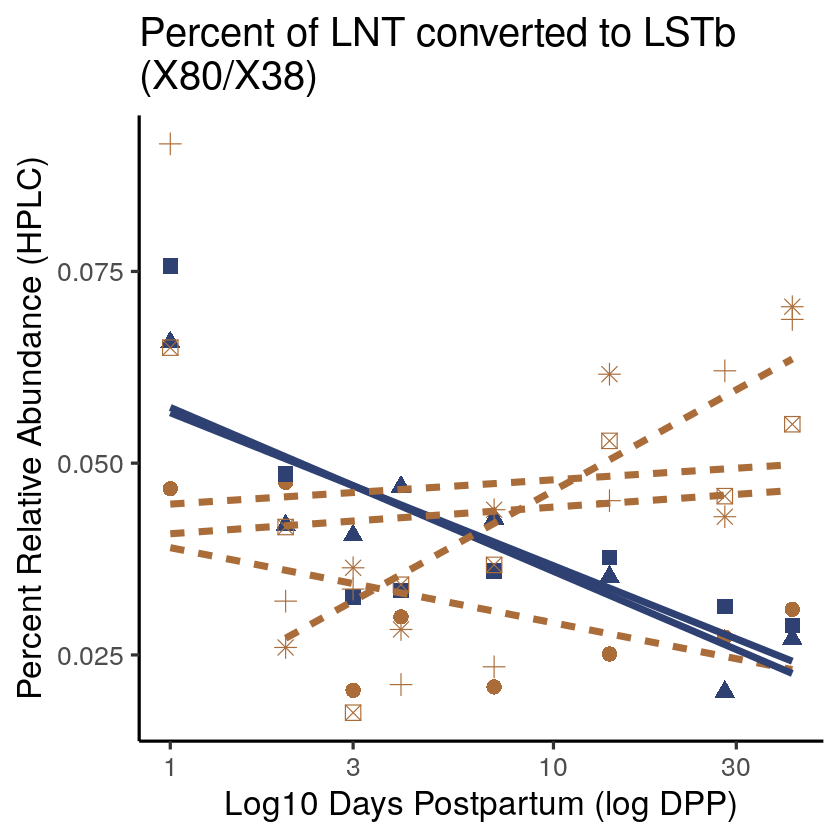

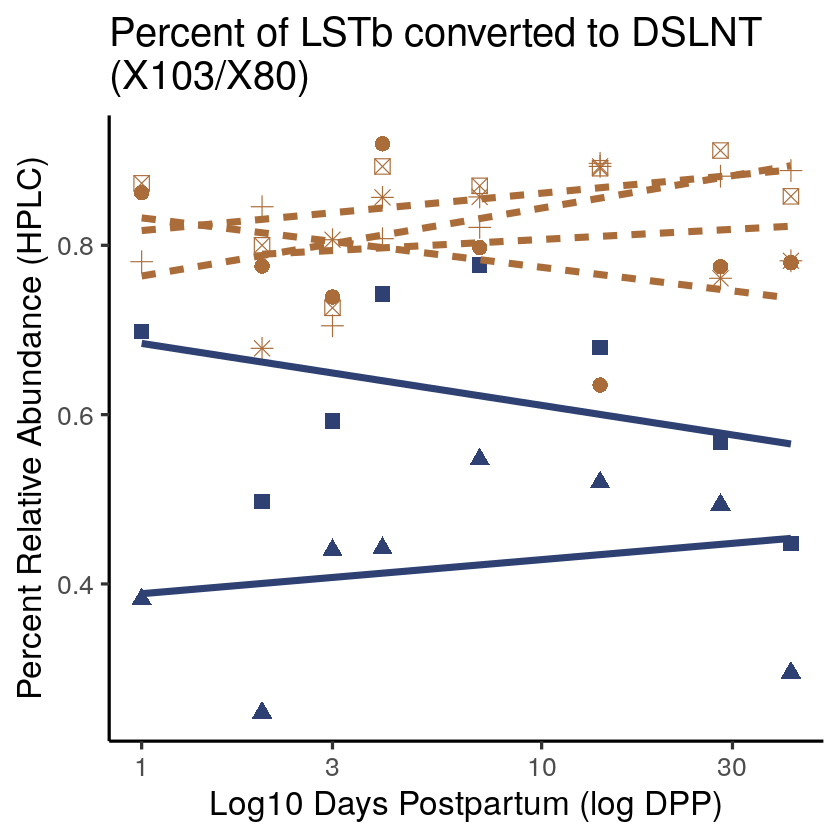

In [77]:

#g = grid.arrange(grobs=list(
    ggplot(data[[1]],aes(x=DPP,y=X80/X38,color=factor(Secretor),linetype=Secretor,shape=PateintID,group=factor(PateintID)))+
        geom_point(size=4,show.legend=F)+stat_smooth(method='lm',size=2,se=F,show.legend=F)+
        theme_classic(base_size=20)+scale_x_log10()+ylab('Percent Relative Abundance (HPLC)')+
        ggtitle("Percent of LNT converted to LSTb\n(X80/X38)")+xlab("Log10 Days Postpartum (log DPP)")+
        scale_color_manual(values=c("#2E4172", "#AA6C39"))#,
    ggplot(data[[1]],aes(x=DPP,y=X103/X80,color=factor(Secretor),linetype=Secretor,shape=PateintID,group=factor(PateintID)))+
        geom_point(size=4,show.legend=F)+stat_smooth(method='lm',size=2,se=F,show.legend=F)+
        theme_classic(base_size=20)+scale_x_log10()+ylab('Percent Relative Abundance (HPLC)')+
        ggtitle("Percent of LSTb converted to DSLNT\n(X103/X80)")+xlab("Log10 Days Postpartum (log DPP)")+
        scale_color_manual(values=c("#2E4172", "#AA6C39"))
#),nrow=2)
#ggsave(g,filename='motifAnyl/motif_heir.12.7.18.Bokan/ratio_trends.pdf',width=13,height=6)

## Using the likelihood ratio test to determine if more complex substructures are significantly more predictive of secretor status 

In [63]:
#### load heirachy
r = read.csv('motifAnyl/motif_heir.12.7.18.Bokan/edges.txt',header=F)
heir = graph_from_edgelist( cbind( as.character(r[,1]) , as.character(r[,2]) ))
#plot(heir, layout=layout_as_tree(heir))

#### data
tmp = data[[1]]

comp=list()
comp_clean=list()
for( e in E(heir)){
    print(ends(heir,e))
    en=as.character(ends(heir,e))
    if(any(! paste0('X',en) %in% colnames(tmp) )){print(paste('skip',paste(en,collapse='_')));next}
    if( !all( apply(tmp[,paste0('X',en)],2,sd) > 1e-4 ) | all( tmp[[paste0('X',en[1])]] == tmp[[paste0('X',en[2])]] ) ){
        print(paste('skip',paste(en,collapse='_')));
        next
    }
    # run models
    f1 = as.formula(paste('Secretor ~',paste0('X',en[1])))
    f2 = as.formula(paste('Secretor ~',paste(paste0('X',en),collapse='+')  ))
    m1 = geeglm( f1, id=PateintID,data=tmp,corstr='exchangeable',family='binomial')
    m2 = geeglm( f2 , id=PateintID,data=tmp,corstr='exchangeable',family='binomial')
    aov = anova(m1,m2,test='LRT')
    out = data.frame( rbind(coef(summary(m1)) , coef(summary(m2))) )
    out$model = c(rep('m1',2),rep('m2',3))
    out$iter = paste(en,collapse='_')
    eni = c('Intercept',en)
    out$vars = c(eni[1:2],eni[1:3])
    out$LRT = aov[[3]]
    if(any(abs(out$Estimate)>15)){next}
    comp[[paste(en,collapse='_')]] = list(m1,m2,aov)
    comp_clean[[paste(en,collapse='_')]] = out
}
head(do.call(rbind,comp_clean))



     [,1] [,2]
[1,] "5"  "20"
[1] "skip 5_20"
     [,1] [,2]
[1,] "5"  "21"
[1] "skip 5_21"
     [,1] [,2]
[1,] "5"  "26"
[1] "skip 5_26"
     [,1] [,2]
[1,] "5"  "29"
[1] "skip 5_29"
     [,1] [,2]
[1,] "5"  "35"
[1] "skip 5_35"
     [,1] [,2]
[1,] "20" "37"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "38"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "40"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "41"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "43"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "51"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "20" "53"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "26" "43"
     [,1] [,2]
[1,] "29" "45"
[1] "skip 29_45"
     [,1] [,2]
[1,] "29" "46"
     [,1] [,2]
[1,] "29" "51"
[1] "skip 29_51"
     [,1] [,2]
[1,] "37" "61"
[1] "skip 37_61"
     [,1] [,2]
[1,] "37" "64"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "61"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "65"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "79"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "80"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "85"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "38" "86"


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "40" "62"
     [,1] [,2]
[1,] "40" "63"
     [,1] [,2]
[1,] "40" "73"
     [,1] [,2]
[1,] "41" "62"
[1] "skip 41_62"
     [,1] [,2]
[1,] "41" "74"
     [,1] [,2]
[1,] "43" "64"
[1] "skip 43_64"
     [,1] [,2]
[1,] "43" "65"
[1] "skip 43_65"
     [,1] [,2]
[1,] "45" "66"
     [,1] [,2]
[1,] "45" "75"
[1] "skip 45_75"
     [,1] [,2]
[1,] "45" "88"
     [,1] [,2]
[1,] "46" "66"
[1] "skip 46_66"
     [,1] [,2]
[1,] "46" "76"
[1] "skip 46_76"
     [,1] [,2]
[1,] "51" "73"
     [,1] [,2]
[1,] "51" "74"
     [,1] [,2]
[1,] "51" "75"
[1] "skip 51_75"
     [,1] [,2]
[1,] "51" "76"
     [,1] [,2]
[1,] "51" "81"
     [,1] [,2]
[1,] "51" "85"
     [,1] [,2]
[1,] "53" "80"
[1] "skip 53_80"
     [,1] [,2]
[1,] "53" "81"
     [,1] [,2]
[1,] "61" "92"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2]
[1,] "62" "97"
     [,1] [,2] 
[1,] "62" "113"
     [,1] [,2] 
[1,] "63" "113"
     [,1] [,2] 
[1,] "63" "116"
     [,1] [,2]
[1,] "64" "92"
[1] "skip 64_92"
     [,1] [,2]
[1,] "65" "92"
[1] "skip 65_92"
     [,1] [,2] 
[1,] "66" "102"
[1] "skip 66_102"
     [,1] [,2]
[1,] "73" "97"
[1] "skip 73_97"
     [,1] [,2]
[1,] "73" "98"
[1] "skip 73_98"
     [,1] [,2] 
[1,] "73" "100"
     [,1] [,2] 
[1,] "73" "116"
     [,1] [,2]
[1,] "74" "97"
[1] "skip 74_97"
     [,1] [,2]
[1,] "74" "99"
[1] "skip 74_99"
     [,1] [,2] 
[1,] "74" "101"
     [,1] [,2]
[1,] "75" "98"
     [,1] [,2]
[1,] "75" "99"
     [,1] [,2] 
[1,] "75" "102"
     [,1] [,2] 
[1,] "75" "104"
     [,1] [,2] 
[1,] "75" "110"
     [,1] [,2] 
[1,] "75" "117"
     [,1] [,2] 
[1,] "76" "100"
[1] "skip 76_100"
     [,1] [,2] 
[1,] "76" "101"
[1] "skip 76_101"
     [,1] [,2] 
[1,] "76" "102"
[1] "skip 76_102"
     [,1] [,2] 
[1,] "79" "103"
[1] "skip 79_103"
     [,1] [,2] 
[1,] "79" "108"
     [,1] [,2] 
[1,] "80" 

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2] 
[1,] "80" "109"
     [,1] [,2] 
[1,] "81" "104"
[1] "skip 81_104"
     [,1] [,2] 
[1,] "81" "109"
[1] "skip 81_109"
     [,1] [,2] 
[1,] "85" "108"
     [,1] [,2] 
[1,] "85" "109"
     [,1] [,2] 
[1,] "85" "110"
[1] "skip 85_110"
     [,1] [,2] 
[1,] "85" "112"
     [,1] [,2] 
[1,] "86" "112"


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

     [,1] [,2] 
[1,] "88" "117"
[1] "skip 88_117"
     [,1] [,2] 
[1,] "97" "121"
[1] "skip 97_121"
     [,1] [,2] 
[1,] "97" "122"
     [,1] [,2] 
[1,] "97" "130"
     [,1] [,2] 
[1,] "98" "121"
[1] "skip 98_121"
     [,1] [,2] 
[1,] "98" "123"
     [,1] [,2] 
[1,] "98" "135"
     [,1] [,2] 
[1,] "98" "136"
     [,1] [,2] 
[1,] "99" "121"
[1] "skip 99_121"
     [,1] [,2] 
[1,] "99" "124"
     [,1] [,2] 
[1,] "99" "131"
     [,1]  [,2] 
[1,] "100" "122"
[1] "skip 100_122"
     [,1]  [,2] 
[1,] "100" "123"
[1] "skip 100_123"
     [,1]  [,2] 
[1,] "101" "122"
[1] "skip 101_122"
     [,1]  [,2] 
[1,] "101" "124"
[1] "skip 101_124"
     [,1]  [,2] 
[1,] "102" "123"
[1] "skip 102_123"
     [,1]  [,2] 
[1,] "102" "124"
[1] "skip 102_124"
     [,1]  [,2] 
[1,] "103" "126"
     [,1]  [,2] 
[1,] "104" "128"
[1] "skip 104_128"
     [,1]  [,2] 
[1,] "108" "126"
[1] "skip 108_126"
     [,1]  [,2] 
[1,] "108" "127"
[1] "skip 108_127"
     [,1]  [,2] 
[1,] "109" "126"
[1] "skip 109_126"
     [,1]  [

,Estimate,Std.err,Wald,Pr...W..,model,iter,vars,LRT
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
26_43.(Intercept),0.69494924,0.86693136,0.6425941,0.4227730,m1,26_43,Intercept,0.1158514
26_43.X26,-0.01889897,0.02903672,0.4236243,0.5151341,m1,26_43,26,0.1158514
26_43.(Intercept)1,0.69710437,0.86682828,0.6467396,0.4212808,m2,26_43,Intercept,0.1158514
26_43.X261,0.09174131,0.06288704,2.1281759,0.1446128,m2,26_43,26,0.1158514
26_43.X43,-0.16576369,0.10543322,2.4718600,0.1159007,m2,26_43,43,0.1158514
53_81.(Intercept),0.68414491,0.86525408,0.6251855,0.4291268,m1,53_81,Intercept,0.9929525


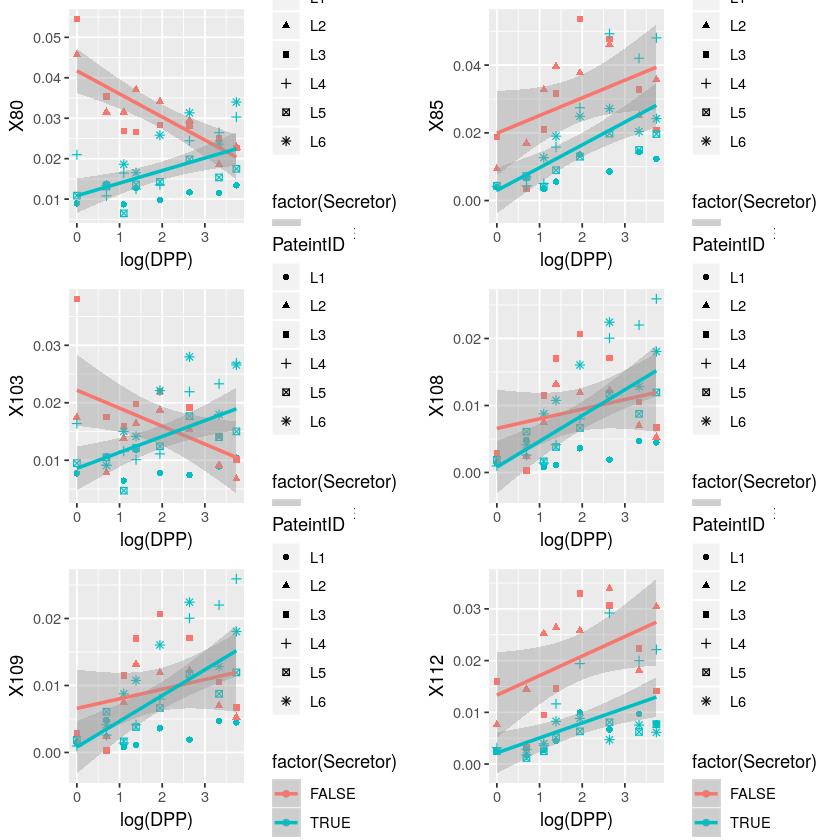

In [61]:
g=grid.arrange(grobs=list(
	ggplot(data[[1]],aes(x=log(DPP),y=X80,color=factor(Secretor),shape=PateintID,group=factor(Secretor)))+geom_point()+stat_smooth(method='lm'),
	ggplot(data[[1]],aes(x=log(DPP),y=X85,color=factor(Secretor),shape=PateintID,group=factor(Secretor)))+geom_point()+stat_smooth(method='lm'),
	ggplot(data[[1]],aes(x=log(DPP),y=X103,color=factor(Secretor),shape=PateintID,group=factor(Secretor)))+geom_point()+stat_smooth(method='lm'),
	ggplot(data[[1]],aes(x=log(DPP),y=X108,color=factor(Secretor),shape=PateintID,group=factor(Secretor)))+geom_point()+stat_smooth(method='lm'),
	ggplot(data[[1]],aes(x=log(DPP),y=X109,color=factor(Secretor),shape=PateintID,group=factor(Secretor)))+geom_point()+stat_smooth(method='lm'),
	ggplot(data[[1]],aes(x=log(DPP),y=X112,color=factor(Secretor),shape=PateintID,group=factor(Secretor)))+geom_point()+stat_smooth(method='lm')
	))

In [73]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.7.1
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.7.1

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] geepack_1.2-1       gee_4.13-19         heatmap.plus_1.3   
 [4] lme4_1.1-21         openxlsx_4.1.0.1    reshape2_1.4.3     
 [7] metap_1.1           GGally_1.4.0        ggrepel_0.8.1      
[10] colorRamps_2.3      stringr_1.4.0       MASS_7.3-51.4 